In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from matplotlib import pyplot as plt

In [2]:
import os
import function_training
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import json

import numpy as np
import tensorflow as tf

from dataLoader import AnyDataset
import function_training
from function_training import confusion_matrix
from config import MLP_model,hyperparameters, args, CNN_model

numBands=100
bands_type="spin up"

import xgboost as xgb

Init Plugin
Init Graph Optimizer
Init Kernel


In [3]:
# step 1. prepare dataset
def json2inputlabel(data_json, bands_type="spin up"):
    _bands_type = {"spin up": "spin_up_bands",
                   "spin down": "spin_down_bands",
                   "soc": "soc_bands"}
    data_input_np = np.array(data_json[_bands_type[bands_type]]) # 100 x 400
    # data_input_np = np.array(data_json[_bands_type[bands_type]]).flataten().T # 40000x1
    data_label_np = np.array([data_json["new_label"]])
    # data_label_np = np.array([data_json["layers_num"]])

    return data_input_np, data_label_np


#take data and set batch size here
train_dataset = AnyDataset("list/actual/train_set.txt", json2inputlabel, args["load"]["numClasses"],bands_type, training=True)
test_dataset = AnyDataset("list/actual/test_set.txt", json2inputlabel, args["load"]["numClasses"],bands_type, training=False)
train_loader = tf.data.Dataset.from_tensor_slices((train_dataset.data_inputs, train_dataset.data_labels)).shuffle(train_dataset.len).batch(hyperparameters['batch_size'])
test_loader = tf.data.Dataset.from_tensor_slices((test_dataset.data_inputs,test_dataset.data_labels)).shuffle(test_dataset.len).batch(hyperparameters['batch_size'])


Loading test set: 100%|██████████████████████| 100/100 [00:00<00:00, 503.38it/s]


Metal device set to: Apple M1 Pro


In [4]:
train_loader2 = tf.data.Dataset.from_tensor_slices((train_dataset.data_inputs,train_dataset.data_labels)).shuffle(train_dataset.len).batch(1000)

# model2 = tf.keras.Sequential(MLP_model)

for element, labels in train_loader2:
#     print (element)
#     print (labels)
#     np.maximum([model(element, training=False)])

#     predict = np.argmax(model.predict(element), axis=-1)
#     label = np.array(labels).flatten()
    break

In [5]:
shape = element.numpy().shape
element_flatten2D_train = element.numpy().reshape(shape[0],shape[1]*shape[2])
labels1D_train = labels.numpy().flatten()

dtrain = xgb.DMatrix(element_flatten2D_train, label=labels1D_train)

In [6]:
test_loader2 = tf.data.Dataset.from_tensor_slices((test_dataset.data_inputs,test_dataset.data_labels)).shuffle(test_dataset.len).batch(1000)

# model2 = tf.keras.Sequential(MLP_model)

for element, labels in test_loader2:
#     print (element)
#     print (labels)
#     np.maximum([model(element, training=False)])

#     predict = np.argmax(model.predict(element), axis=-1)
#     label = np.array(labels).flatten()
    break
    
shape = element.numpy().shape
element_flatten2D_test = element.numpy().reshape(shape[0],shape[1]*shape[2])
labels1D_test = labels.numpy().flatten()

dtest = xgb.DMatrix(element_flatten2D_test, label=labels1D_test)

In [7]:
watchlist = [(dtest, 'eval'), (dtrain, 'train')]
###
# advanced: start from a initial base prediction
#
print('start running example to start from a initial prediction')
# specify parameters via map, definition are same as c++ version
param = {'max_depth': 30, 'eta': 0.002, 'lambda':0, 'alpha':0, 'num_class': 5, 'objective':'multi:softmax'}
# train xgboost for 1 round
bst = xgb.train(param, dtrain, 1000, watchlist, early_stopping_rounds=50)
# Note: we need the margin value instead of transformed prediction in
# set_base_margin
# do predict with output_margin=True, will always give you margin values
# before logistic transformation
ptrain = bst.predict(dtrain)
ptest = bst.predict(dtest)

start running example to start from a initial prediction
[19:21:43] WARNING: /Users/ktietz/demo/mc3/conda-bld/xgboost-split_1628682908089/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-mlogloss:1.60750	train-mlogloss:1.60519
[1]	eval-mlogloss:1.60562	train-mlogloss:1.60093
[2]	eval-mlogloss:1.60365	train-mlogloss:1.59670
[3]	eval-mlogloss:1.60170	train-mlogloss:1.59248
[4]	eval-mlogloss:1.59973	train-mlogloss:1.58829
[5]	eval-mlogloss:1.59779	train-mlogloss:1.58413
[6]	eval-mlogloss:1.59575	train-mlogloss:1.57997
[7]	eval-mlogloss:1.59397	train-mlogloss:1.57582
[8]	eval-mlogloss:1.59211	train-mlogloss:1.57170
[9]	eval-mlogloss:1.59017	train-mlogloss:1.56762
[10]	eval-mlogloss:1.58831	train-mlogloss:1.56355
[11]	eval-mlogloss:1.58658	train-mlogloss:1.55947
[12]	eval-mlogloss:1.58475	train-mlogl

[156]	eval-mlogloss:1.38865	train-mlogloss:1.09313
[157]	eval-mlogloss:1.38775	train-mlogloss:1.09061
[158]	eval-mlogloss:1.38685	train-mlogloss:1.08810
[159]	eval-mlogloss:1.38597	train-mlogloss:1.08560
[160]	eval-mlogloss:1.38495	train-mlogloss:1.08310
[161]	eval-mlogloss:1.38391	train-mlogloss:1.08062
[162]	eval-mlogloss:1.38289	train-mlogloss:1.07814
[163]	eval-mlogloss:1.38175	train-mlogloss:1.07567
[164]	eval-mlogloss:1.38074	train-mlogloss:1.07319
[165]	eval-mlogloss:1.37974	train-mlogloss:1.07075
[166]	eval-mlogloss:1.37874	train-mlogloss:1.06830
[167]	eval-mlogloss:1.37769	train-mlogloss:1.06587
[168]	eval-mlogloss:1.37673	train-mlogloss:1.06344
[169]	eval-mlogloss:1.37566	train-mlogloss:1.06102
[170]	eval-mlogloss:1.37467	train-mlogloss:1.05861
[171]	eval-mlogloss:1.37381	train-mlogloss:1.05620
[172]	eval-mlogloss:1.37285	train-mlogloss:1.05380
[173]	eval-mlogloss:1.37181	train-mlogloss:1.05140
[174]	eval-mlogloss:1.37094	train-mlogloss:1.04902
[175]	eval-mlogloss:1.37002	tra

[317]	eval-mlogloss:1.25524	train-mlogloss:0.76856
[318]	eval-mlogloss:1.25451	train-mlogloss:0.76696
[319]	eval-mlogloss:1.25380	train-mlogloss:0.76536
[320]	eval-mlogloss:1.25309	train-mlogloss:0.76375
[321]	eval-mlogloss:1.25242	train-mlogloss:0.76217
[322]	eval-mlogloss:1.25181	train-mlogloss:0.76058
[323]	eval-mlogloss:1.25120	train-mlogloss:0.75898
[324]	eval-mlogloss:1.25071	train-mlogloss:0.75739
[325]	eval-mlogloss:1.25008	train-mlogloss:0.75583
[326]	eval-mlogloss:1.24960	train-mlogloss:0.75425
[327]	eval-mlogloss:1.24903	train-mlogloss:0.75268
[328]	eval-mlogloss:1.24848	train-mlogloss:0.75111
[329]	eval-mlogloss:1.24788	train-mlogloss:0.74955
[330]	eval-mlogloss:1.24742	train-mlogloss:0.74799
[331]	eval-mlogloss:1.24690	train-mlogloss:0.74644
[332]	eval-mlogloss:1.24641	train-mlogloss:0.74488
[333]	eval-mlogloss:1.24580	train-mlogloss:0.74334
[334]	eval-mlogloss:1.24534	train-mlogloss:0.74179
[335]	eval-mlogloss:1.24481	train-mlogloss:0.74025
[336]	eval-mlogloss:1.24414	tra

[478]	eval-mlogloss:1.17622	train-mlogloss:0.55506
[479]	eval-mlogloss:1.17582	train-mlogloss:0.55397
[480]	eval-mlogloss:1.17542	train-mlogloss:0.55287
[481]	eval-mlogloss:1.17500	train-mlogloss:0.55179
[482]	eval-mlogloss:1.17459	train-mlogloss:0.55071
[483]	eval-mlogloss:1.17423	train-mlogloss:0.54962
[484]	eval-mlogloss:1.17383	train-mlogloss:0.54855
[485]	eval-mlogloss:1.17341	train-mlogloss:0.54748
[486]	eval-mlogloss:1.17304	train-mlogloss:0.54641
[487]	eval-mlogloss:1.17263	train-mlogloss:0.54534
[488]	eval-mlogloss:1.17220	train-mlogloss:0.54427
[489]	eval-mlogloss:1.17186	train-mlogloss:0.54321
[490]	eval-mlogloss:1.17145	train-mlogloss:0.54215
[491]	eval-mlogloss:1.17113	train-mlogloss:0.54109
[492]	eval-mlogloss:1.17071	train-mlogloss:0.54004
[493]	eval-mlogloss:1.17034	train-mlogloss:0.53898
[494]	eval-mlogloss:1.16988	train-mlogloss:0.53794
[495]	eval-mlogloss:1.16948	train-mlogloss:0.53690
[496]	eval-mlogloss:1.16916	train-mlogloss:0.53585
[497]	eval-mlogloss:1.16875	tra

[639]	eval-mlogloss:1.12613	train-mlogloss:0.40738
[640]	eval-mlogloss:1.12588	train-mlogloss:0.40661
[641]	eval-mlogloss:1.12556	train-mlogloss:0.40584
[642]	eval-mlogloss:1.12535	train-mlogloss:0.40508
[643]	eval-mlogloss:1.12511	train-mlogloss:0.40432
[644]	eval-mlogloss:1.12487	train-mlogloss:0.40356
[645]	eval-mlogloss:1.12463	train-mlogloss:0.40280
[646]	eval-mlogloss:1.12441	train-mlogloss:0.40204
[647]	eval-mlogloss:1.12411	train-mlogloss:0.40129
[648]	eval-mlogloss:1.12384	train-mlogloss:0.40052
[649]	eval-mlogloss:1.12365	train-mlogloss:0.39977
[650]	eval-mlogloss:1.12336	train-mlogloss:0.39902
[651]	eval-mlogloss:1.12304	train-mlogloss:0.39826
[652]	eval-mlogloss:1.12286	train-mlogloss:0.39752
[653]	eval-mlogloss:1.12262	train-mlogloss:0.39677
[654]	eval-mlogloss:1.12232	train-mlogloss:0.39601
[655]	eval-mlogloss:1.12207	train-mlogloss:0.39527
[656]	eval-mlogloss:1.12185	train-mlogloss:0.39453
[657]	eval-mlogloss:1.12155	train-mlogloss:0.39378
[658]	eval-mlogloss:1.12129	tra

[800]	eval-mlogloss:1.09014	train-mlogloss:0.30240
[801]	eval-mlogloss:1.09002	train-mlogloss:0.30185
[802]	eval-mlogloss:1.08986	train-mlogloss:0.30131
[803]	eval-mlogloss:1.08971	train-mlogloss:0.30076
[804]	eval-mlogloss:1.08955	train-mlogloss:0.30022
[805]	eval-mlogloss:1.08941	train-mlogloss:0.29968
[806]	eval-mlogloss:1.08926	train-mlogloss:0.29913
[807]	eval-mlogloss:1.08917	train-mlogloss:0.29860
[808]	eval-mlogloss:1.08900	train-mlogloss:0.29806
[809]	eval-mlogloss:1.08881	train-mlogloss:0.29752
[810]	eval-mlogloss:1.08868	train-mlogloss:0.29698
[811]	eval-mlogloss:1.08855	train-mlogloss:0.29644
[812]	eval-mlogloss:1.08843	train-mlogloss:0.29590
[813]	eval-mlogloss:1.08827	train-mlogloss:0.29537
[814]	eval-mlogloss:1.08814	train-mlogloss:0.29484
[815]	eval-mlogloss:1.08796	train-mlogloss:0.29430
[816]	eval-mlogloss:1.08779	train-mlogloss:0.29377
[817]	eval-mlogloss:1.08765	train-mlogloss:0.29323
[818]	eval-mlogloss:1.08750	train-mlogloss:0.29270
[819]	eval-mlogloss:1.08739	tra

[961]	eval-mlogloss:1.06955	train-mlogloss:0.22773
[962]	eval-mlogloss:1.06943	train-mlogloss:0.22733
[963]	eval-mlogloss:1.06935	train-mlogloss:0.22694
[964]	eval-mlogloss:1.06923	train-mlogloss:0.22655
[965]	eval-mlogloss:1.06913	train-mlogloss:0.22617
[966]	eval-mlogloss:1.06897	train-mlogloss:0.22578
[967]	eval-mlogloss:1.06887	train-mlogloss:0.22539
[968]	eval-mlogloss:1.06875	train-mlogloss:0.22500
[969]	eval-mlogloss:1.06863	train-mlogloss:0.22461
[970]	eval-mlogloss:1.06852	train-mlogloss:0.22423
[971]	eval-mlogloss:1.06838	train-mlogloss:0.22384
[972]	eval-mlogloss:1.06826	train-mlogloss:0.22346
[973]	eval-mlogloss:1.06813	train-mlogloss:0.22307
[974]	eval-mlogloss:1.06801	train-mlogloss:0.22269
[975]	eval-mlogloss:1.06792	train-mlogloss:0.22231
[976]	eval-mlogloss:1.06780	train-mlogloss:0.22192
[977]	eval-mlogloss:1.06768	train-mlogloss:0.22154
[978]	eval-mlogloss:1.06754	train-mlogloss:0.22116
[979]	eval-mlogloss:1.06743	train-mlogloss:0.22078
[980]	eval-mlogloss:1.06730	tra

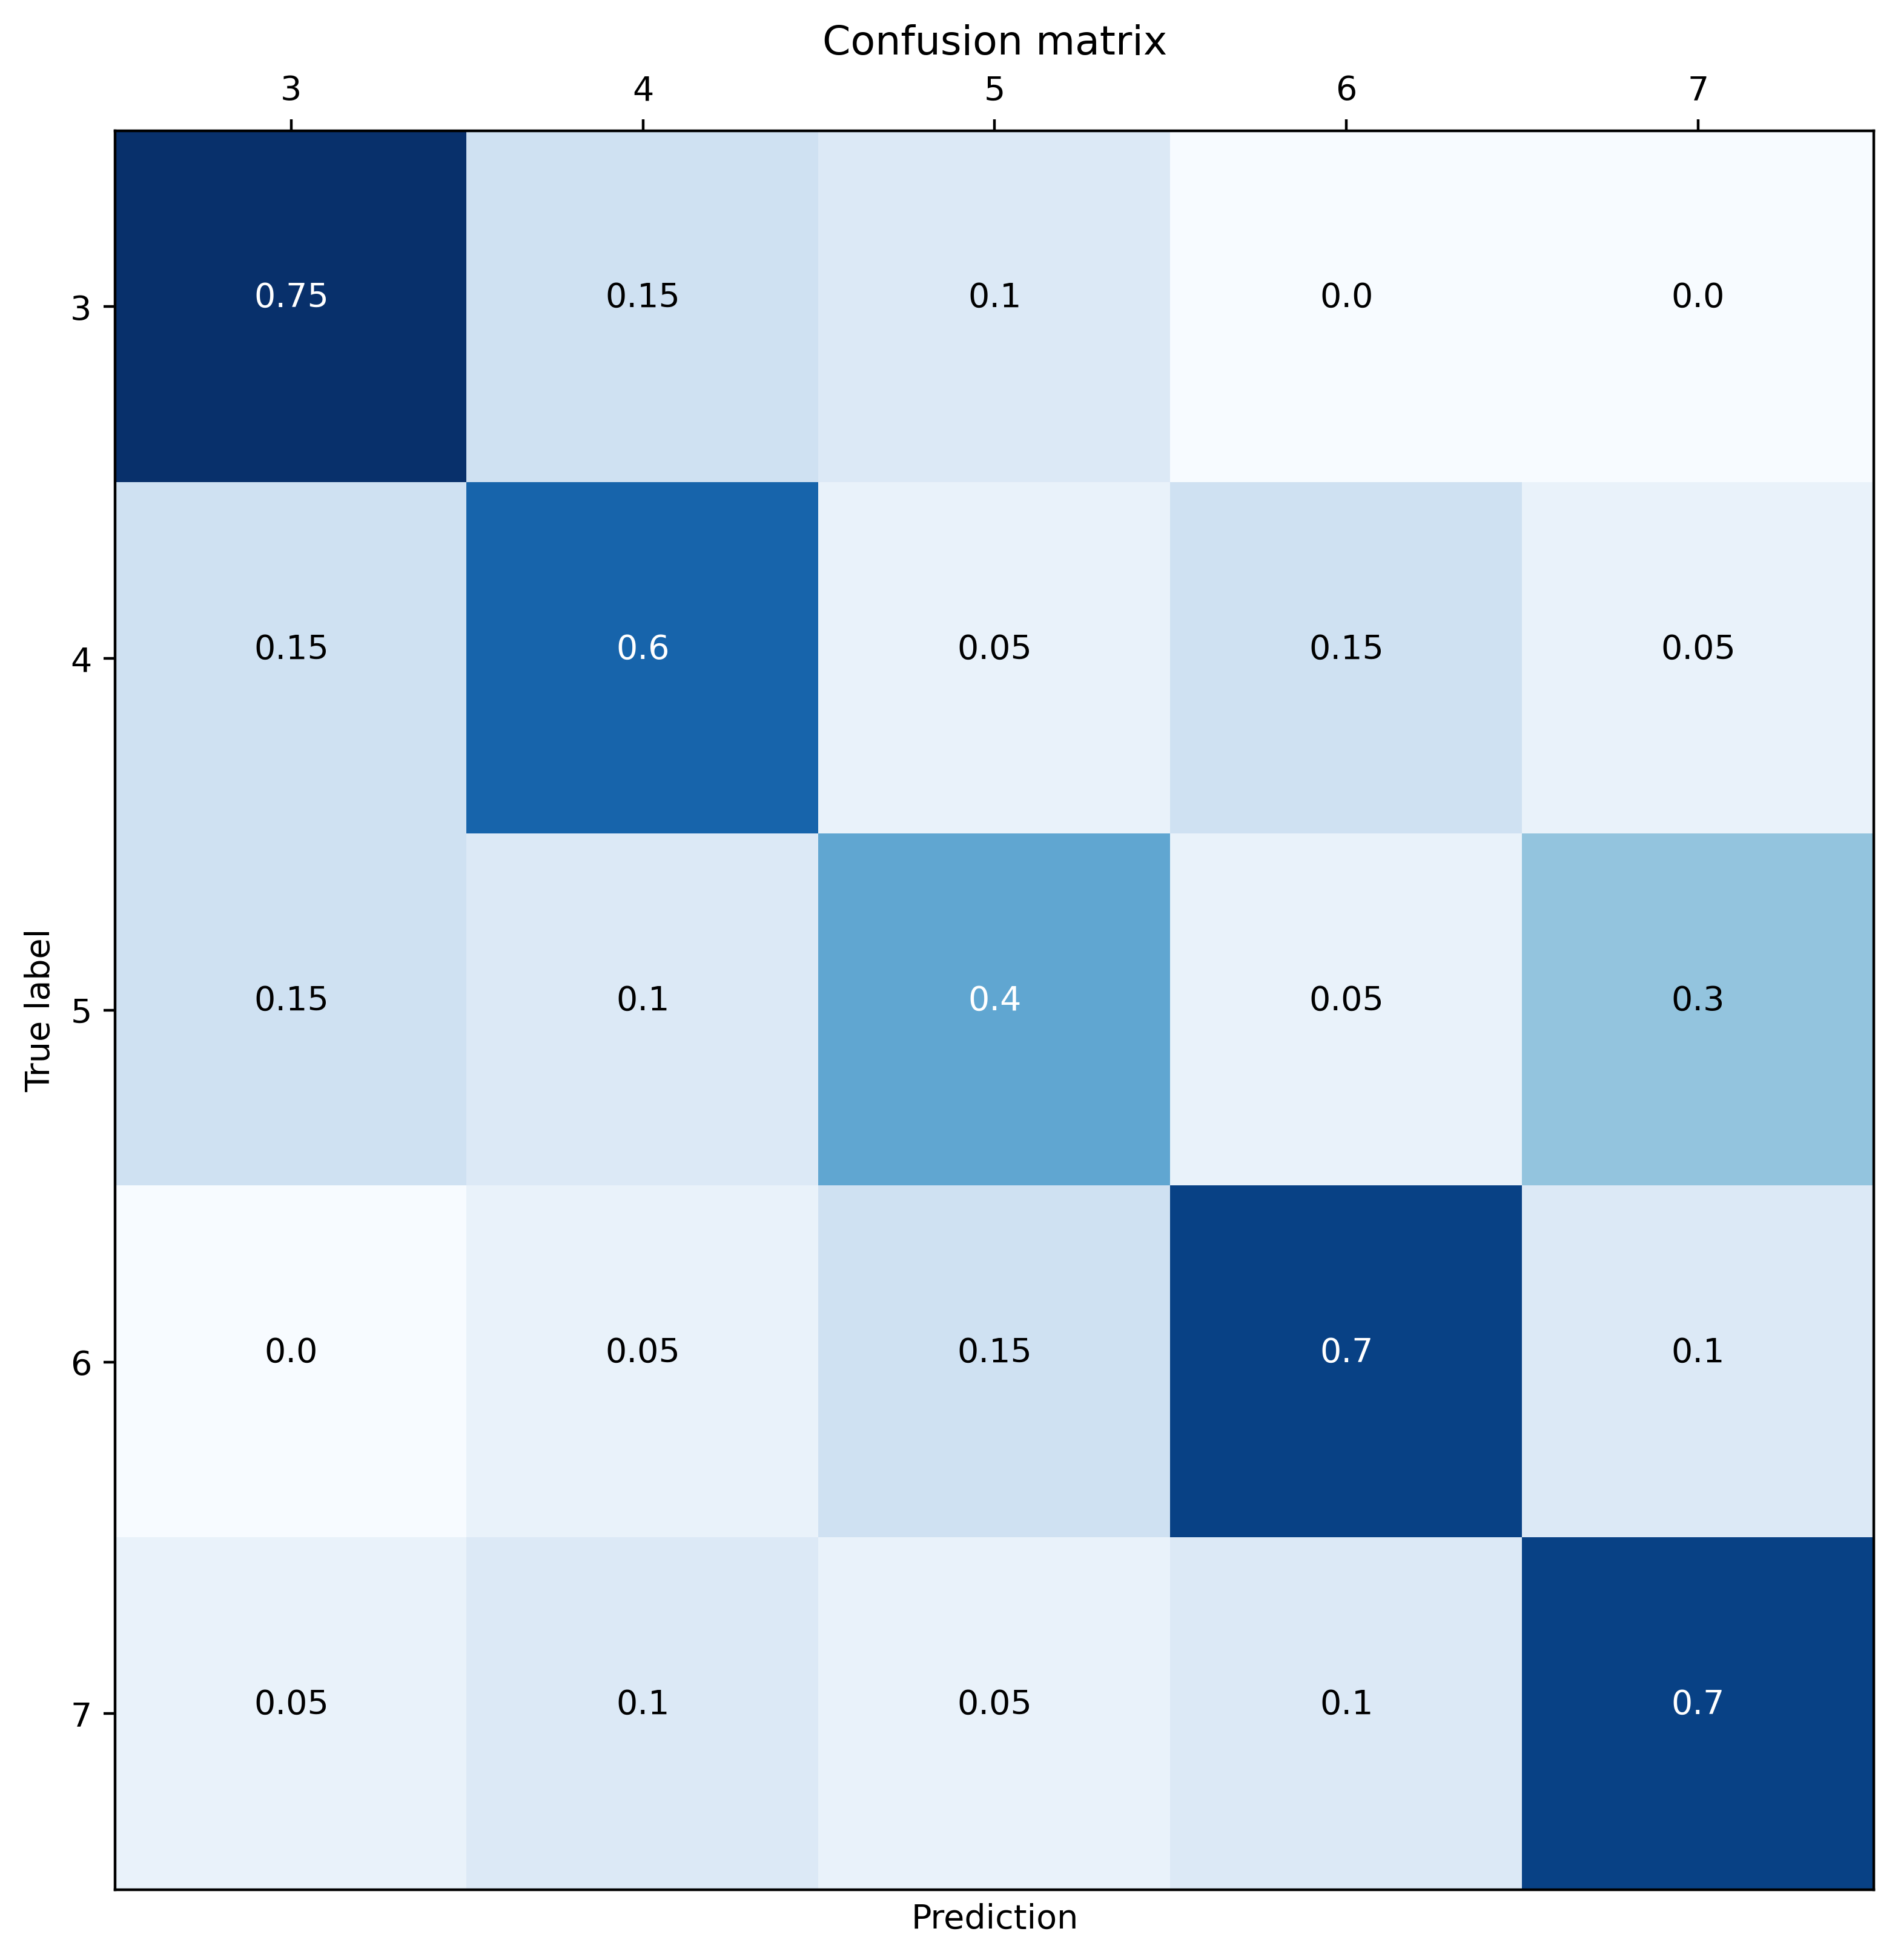

In [8]:
confusion_matrix(labels=labels1D_test, predictions=ptest, class_names=[3, 4, 5, 6, 7])

In [9]:
# m = tf.keras.metrics.SparseCategoricalAccuracy()
# m.update_state(labels1D_test.reshape(1,100).shape, ptest.reshape(1,100).shape)
# m.result().numpy()

In [10]:
from sklearn.metrics import accuracy_score
mse = accuracy_score(y_true=labels1D_test, y_pred=ptest)
mse
# test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
# print (test_accuracy(labels1D_test.reshape(labels1D_test.shape[0],1), ptest.reshape(ptest.shape[0],1)))

0.63

<Figure size 4800x4000 with 0 Axes>

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

<Figure size 4800x4000 with 0 Axes>

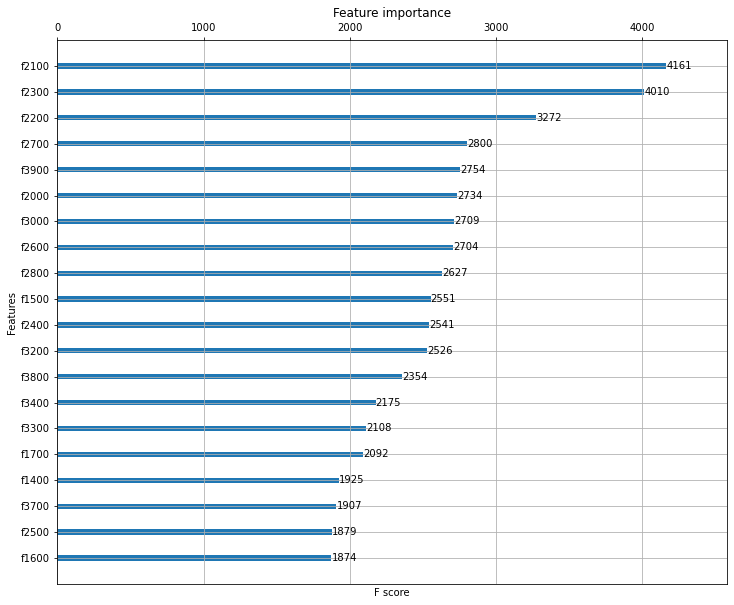

In [11]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12,10
plt.figure(dpi=400)
xgb.plot_importance(bst, max_num_features=20)

<Figure size 32000x20000 with 0 Axes>

<AxesSubplot:>

<Figure size 32000x20000 with 0 Axes>

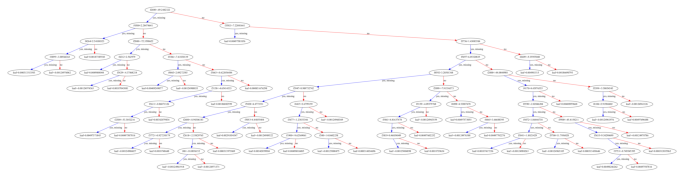

In [12]:
from matplotlib.pylab import rcParams
# rcParams['figure.figsize'] = 80,50
plt.figure(figsize=(80, 50), dpi=400)
xgb.plot_tree(bst, num_trees=5)

In [13]:
results = bst.evals_result()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.axvline(21, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

AttributeError: 'Booster' object has no attribute 'evals_result'